# AOUIDA WAJIH

# IMPORTATIONS & SETUP


In [ ]:
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install kaggle --upgrade

!mkdir -p ~/.kaggle


In [ ]:
!kaggle datasets download -d shivam2503/diamonds


Dataset URL: https://www.kaggle.com/datasets/shivam2503/diamonds
License(s): unknown
diamonds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Importations générales
import os
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prétraitement et validation croisée
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modèles pour régression et classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor, Ridge
from sklearn.neural_network import MLPClassifier

# Calibration et évaluation des modèles
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report
)

# Mapie pour régression et classification conformes
from mapie.regression import MapieRegressor
from mapie.classification import MapieClassifier

# Configuration générale
warnings.filterwarnings("ignore")
print("Importations et setup terminés.")


Importations et setup terminés.


In [ ]:

zip_folder = '/content/'

for file in os.listdir(zip_folder):
    if file.endswith('.zip'):
        zip_path = os.path.join(zip_folder, file)
        # Décompresser le fichier
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(zip_folder)
            print(f'{file} décompressé avec succès !')


Wednesday-workingHours.pcap_ISCX.csv.zip décompressé avec succès !
diamonds.zip décompressé avec succès !
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv.zip décompressé avec succès !
KDDTest+.txt.zip décompressé avec succès !
Monday-WorkingHours.pcap_ISCX.csv.zip décompressé avec succès !
KDDTrain+.txt.zip décompressé avec succès !
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv.zip décompressé avec succès !


# Régression Quantile

## Introduction

Dans cette section, nous explorons la **régression quantile** en l'appliquant initialement au dataset **CSE-CIC-IDS2018**.  
Cependant, en raison de **résultats initiaux peu satisfaisants** (faible R² et taux de couverture), nous avons décidé d'approfondir notre analyse en testant cette méthode sur un deuxième dataset, **Diamonds**.

### Démarche :
1. **Étape 1 : Dataset CSE-CIC-IDS2018**  
   - Nous avons mis en œuvre la régression quantile pour estimer les quantiles Q=0.1, Q=0.5 (médian), et Q=0.9.  
   - Les performances initiales, avec des métriques telles que le R² et la couverture, n'étaient pas satisfaisantes.  
   - Cela a motivé un ajustement des paramètres et une exploration complémentaire avec un autre dataset.

2. **Étape 2 : Dataset Diamonds**  
   - Nous avons utilisé ce dataset pour mieux comprendre les performances de la régression quantile.  
   - Les résultats obtenus sur ce dataset ont permis de valider la méthode et d'identifier les points d'amélioration.

3. **Étape 3 : Révision sur le dataset CSE-CIC-IDS2018**  
   - En ajustant les paramètres et en modifiant les étapes de prétraitement, nous avons obtenu de **meilleurs résultats sur le dataset CSE-CIC-IDS2018**, avec un R² plus élevé et un meilleur taux de couverture.



## Dataset 1 : CSE-CIC-IDS2018
#### Description :
Le dataset **CSE-CIC-IDS2018** contient des exemples de trafic réseau avec des caractéristiques liées aux attaques et au trafic normal.  
Les fichiers utilisés pour cette analyse sont :
- `Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv` : Exemples de trafic réseau associés à des attaques DDoS.
- `Wednesday-workingHours.pcap_ISCX.csv` : Exemples de trafic réseau associés à des attaques Brute Force et SSH Patator.

In [ ]:

# Charger les fichiers CSV
file1 = 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
file2 = 'Wednesday-workingHours.pcap_ISCX.csv'

df1_sample = pd.read_csv(file1, nrows=10000)
df2_sample = pd.read_csv(file2, nrows=10000)

# Combiner les échantillons
df = pd.concat([df1_sample, df2_sample], ignore_index=True)


In [ ]:
df.columns = df.columns.str.strip()



=== RÉGRESSION QUANTILE : CSE-CIC-IDS2018 ===


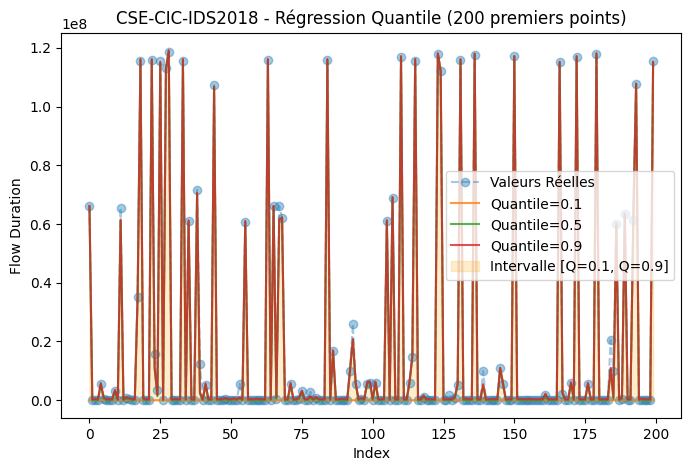

CSE-CIC-IDS2018 - Q=0.5 => MSE=3653968272712.87, R²=0.997
Taux de couverture (intervalle [Q=0.1, Q=0.9]) : 80.20%


In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
df[non_numeric_columns] = df[non_numeric_columns].fillna("Unknown")

# Vérifications
assert not df.isnull().any().any(), "Le DataFrame contient encore des NaN après le nettoyage !"
assert not (df == np.inf).any().any(), "Le DataFrame contient encore des valeurs infinies après le nettoyage !"


# Sélection des colonnes
target_column = "Flow Duration"
feature_columns = [col for col in df.columns if col != target_column and col != "Label"]

X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_columns)  # Normalisation des colonnes numériques
    ]
)

# Régression quantile avec calcul de la couverture
print("=== RÉGRESSION QUANTILE : CSE-CIC-IDS2018 ===")
quantiles_to_test = [0.1, 0.5, 0.9]
preds_q = {}

for q in quantiles_to_test:
    model_q = Pipeline([
        ("preprocessor", preprocessor),
        ("quantreg", QuantileRegressor(quantile=q, alpha=0.1, solver="highs"))
    ])
    model_q.fit(X_train, y_train)
    preds_q[q] = model_q.predict(X_test)

# Calcul de la couverture pour les quantiles 0.1 et 0.9
lower_bound = preds_q[0.1]
upper_bound = preds_q[0.9]

# Taux de couverture : proportion des valeurs réelles incluses dans l'intervalle [q=0.1, q=0.9]
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

# Visualisation des résultats
plt.figure(figsize=(8, 5))
plt.plot(y_test.values[:200], label="Valeurs Réelles", marker="o", linestyle="--", alpha=0.4)
for q in quantiles_to_test:
    plt.plot(preds_q[q][:200], label=f"Quantile={q}", alpha=0.8)
plt.fill_between(range(200), lower_bound[:200], upper_bound[:200], color='orange', alpha=0.2, label="Intervalle [Q=0.1, Q=0.9]")
plt.title("CSE-CIC-IDS2018 - Régression Quantile (200 premiers points)")
plt.xlabel("Index")
plt.ylabel(target_column)
plt.legend()
plt.show()

# Affichage des métriques
mse_q50 = mean_squared_error(y_test, preds_q[0.5])
r2_q50 = r2_score(y_test, preds_q[0.5])
print(f"CSE-CIC-IDS2018 - Q=0.5 => MSE={mse_q50:.2f}, R²={r2_q50:.3f}")
print(f"Taux de couverture (intervalle [Q=0.1, Q=0.9]) : {coverage:.2%}")


## Dataset 2 : Diamonds
#### Description :
Le dataset **Diamonds** contient des informations sur des diamants, incluant leur prix et leurs caractéristiques.  
Les colonnes utilisées incluent des caractéristiques numériques et catégoriques :
- **Numériques** : `carat`, `depth`, `table`.
- **Catégoriques** : `cut`, `color`, `clarity`.
- **Cible** : `price` (prix du diamant).


In [ ]:
# Diamonds dataset
df_diamonds = pd.read_csv('diamonds.csv')

print("Dataset chargé : diamonds")


Dataset chargé : diamonds


In [ ]:
print("Taille actuelle de df_diamonds :", len(df_diamonds))


Taille actuelle de df_diamonds : 53940


In [ ]:
df_diamonds = df_diamonds.sample(n=10000, random_state=42)


In [ ]:
print("Taille actuelle de df_diamonds :", len(df_diamonds))


Taille actuelle de df_diamonds : 10000


In [ ]:
print("=== Diamonds: aperçu ===")
print(df_diamonds.head(), "\n")
df_diamonds.dropna(inplace=True)

# Variables
features_diamonds = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']
target_diamonds   = 'price'

# Séparer X et y
X_dia = df_diamonds[features_diamonds]
y_dia = df_diamonds[target_diamonds]

num_features_dia = ['carat','depth','table']
cat_features_dia = ['cut','color','clarity']

preprocessor_dia = ColumnTransformer([
    ("num_scaler", StandardScaler(), num_features_dia),
    ("cat_encoder", OneHotEncoder(), cat_features_dia)
])


X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(
    X_dia, y_dia, test_size=0.2, random_state=42
)

=== Diamonds: aperçu ===
       Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
1388         1389   0.24      Ideal     G    VVS1   62.1   56.0    559  3.97   
50052       50053   0.58  Very Good     F    VVS2   60.0   57.0   2201  5.44   
41645       41646   0.40      Ideal     E    VVS2   62.1   55.0   1238  4.76   
42377       42378   0.43    Premium     E    VVS2   60.8   57.0   1304  4.92   
17244       17245   1.55      Ideal     E     SI2   62.3   55.0   6901  7.44   

          y     z  
1388   4.00  2.47  
50052  5.42  3.26  
41645  4.74  2.95  
42377  4.89  2.98  
17244  7.37  4.61   



=== RÉGRESSION QUANTILE : DIAMONDS ===


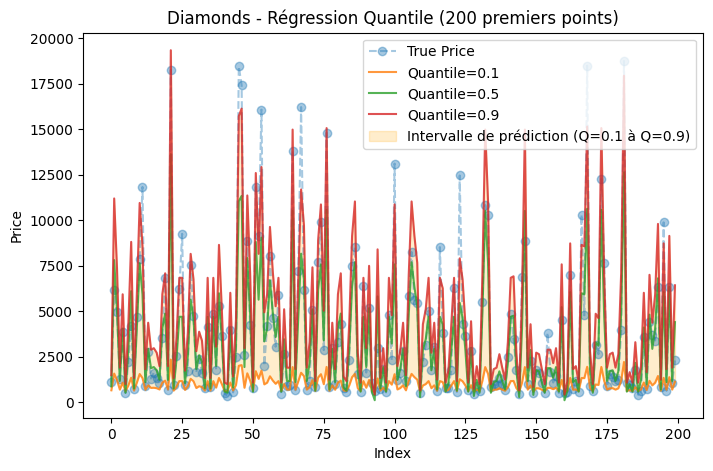

Diamonds - Q=0.5 => MSE=3483205.27, R²=0.784
Coverage (proportion des valeurs réelles dans l'intervalle Q=0.1 à Q=0.9): 82.90%


In [ ]:
print("=== RÉGRESSION QUANTILE : DIAMONDS ===")
quantiles_to_test = [0.1, 0.5, 0.9]
preds_dia_q = {}

# Entraînement et prédictions pour chaque quantile
for q in quantiles_to_test:
    model_q = Pipeline([
        ("preprocessor", preprocessor_dia),
        ("quantreg", QuantileRegressor(quantile=q, alpha=0.1, solver="highs"))
    ])
    model_q.fit(X_train_dia, y_train_dia)
    preds_dia_q[q] = model_q.predict(X_test_dia)

# Calcul de la couverture (Coverage)
lower_quantile = preds_dia_q[0.1]  # Prédictions pour Q=0.1
upper_quantile = preds_dia_q[0.9]  # Prédictions pour Q=0.9

# Vérification si les valeurs réelles sont dans l'intervalle
coverage = np.mean((y_test_dia >= lower_quantile) & (y_test_dia <= upper_quantile))

# Affichage des prédictions et des intervalles
plt.figure(figsize=(8, 5))
plt.plot(y_test_dia.values[:200], label="True Price", marker="o", linestyle="--", alpha=0.4)
for q in quantiles_to_test:
    plt.plot(preds_dia_q[q][:200], label=f"Quantile={q}", alpha=0.8)
plt.fill_between(
    range(200),
    lower_quantile[:200],
    upper_quantile[:200],
    color="orange",
    alpha=0.2,
    label="Intervalle de prédiction (Q=0.1 à Q=0.9)"
)
plt.title("Diamonds - Régression Quantile (200 premiers points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

# Exemple de scores pour le quantile médian (0.5)
mse_dia_q50 = mean_squared_error(y_test_dia, preds_dia_q[0.5])
r2_dia_q50 = r2_score(y_test_dia, preds_dia_q[0.5])

# Affichage des résultats
print(f"Diamonds - Q=0.5 => MSE={mse_dia_q50:.2f}, R²={r2_dia_q50:.3f}")
print(f"Coverage (proportion des valeurs réelles dans l'intervalle Q=0.1 à Q=0.9): {coverage:.2%}")


# Régression conforme


## Introduction

Dans cette section, nous appliquons la **régression conforme** pour évaluer les intervalles de prédiction sur deux datasets distincts : **NSL-KDD** et **Diamonds**.

### Méthodes utilisées :
1. **Régression Conforme avec CV+ (Cross-Validation Plus)**  
   - Cette méthode utilise une validation croisée pour estimer les intervalles de prédiction.  
   - Elle permet de calculer des intervalles robustes tout en prenant en compte l'incertitude des modèles.

2. **Régression Conforme avec Jackknife+**  
   - Une variante basée sur le Jackknife qui estime les intervalles en s'appuyant sur des sous-échantillons des données.  
   - C'est une méthode adaptée aux petits datasets ou lorsque les conditions pour la validation croisée sont moins adaptées.



## Dataset 1 : NSL-KDD
- Ce dataset est utilisé pour prédire la variable `dst_bytes` (nombre d'octets envoyés à la destination) à partir de plusieurs caractéristiques.  
- Nous utilisons la méthode CV+ pour construire des intervalles de prédiction.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mean Absolute Error: 17.99
R² (Coefficient de détermination): 0.998
Taille moyenne des intervalles (95%): 114.26
Coverage (95%): 0.97


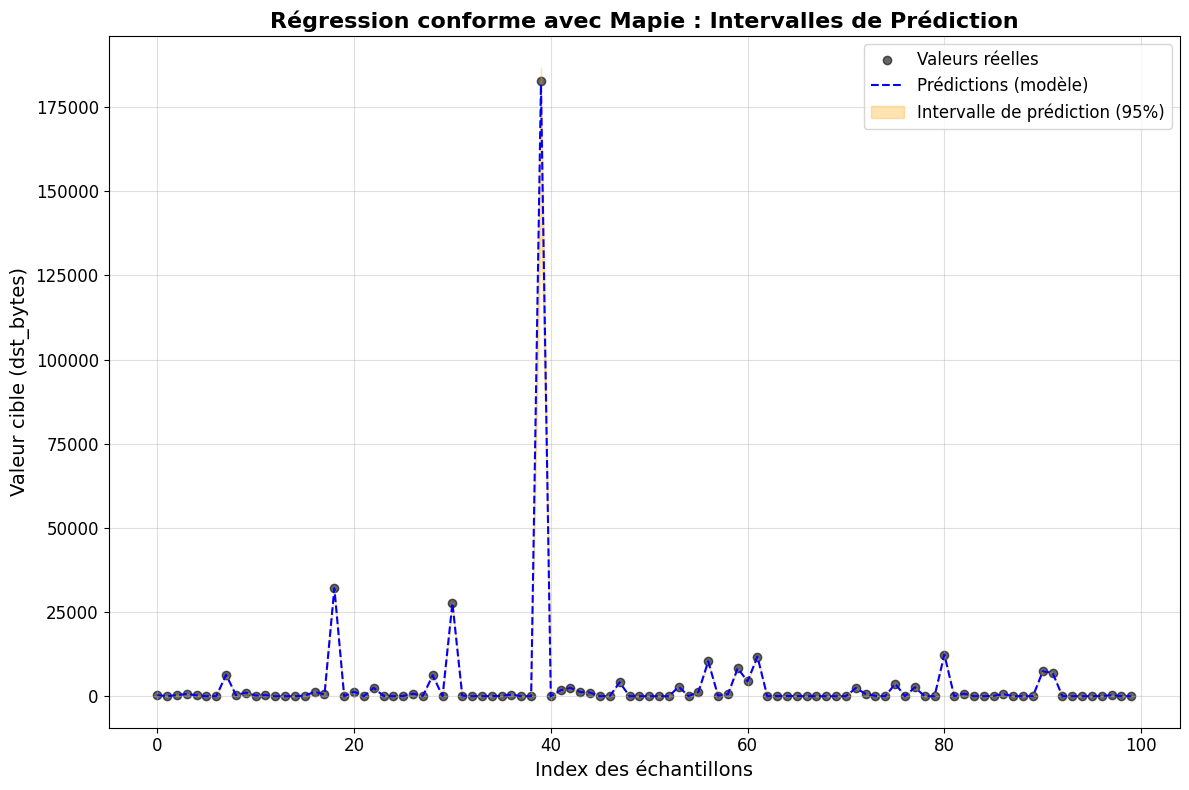

In [ ]:

# Chargement des fichiers NSL-KDD
file_train = "KDDTrain+.txt"
file_test = "KDDTest+.txt"

# Les colonnes sont définies selon la documentation du dataset
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty_level"
]

data_train = pd.read_csv(file_train, names=columns, header=None)
data_test = pd.read_csv(file_test, names=columns, header=None)

sample_size = 10000
data_train = data_train.sample(n=sample_size, random_state=42)
data_test = data_test.sample(n=int(sample_size * 0.2), random_state=42)

categorical_columns = ["protocol_type", "service", "flag"]
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data_train[col] = le.fit_transform(data_train[col])
    label_encoders[col] = le

    known_categories = set(le.classes_)
    test_categories = set(data_test[col].unique())
    unseen_categories = test_categories - known_categories

    if unseen_categories:
        le.classes_ = np.append(le.classes_, list(unseen_categories))

    data_test[col] = le.transform(data_test[col])

selected_columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes"]
X_train = data_train[selected_columns]
y_train = data_train["dst_bytes"]
X_test = data_test[selected_columns]
y_test = data_test["dst_bytes"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Recherche d'hyperparamètres pour Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

mapie = MapieRegressor(estimator=best_rf, cv=KFold(n_splits=5, shuffle=True, random_state=42), method="plus")
mapie.fit(X_train, y_train)

alpha_list = [0.05, 0.10, 0.20]
y_pred, pred_intervals = mapie.predict(X_test, alpha=alpha_list)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
avg_interval_size = np.mean(pred_intervals[:, 1, 0] - pred_intervals[:, 0, 0])

# Calcul de la couverture (proportion des valeurs réelles dans les intervalles)
coverage = np.mean((y_test >= pred_intervals[:, 0, 0]) & (y_test <= pred_intervals[:, 1, 0]))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² (Coefficient de détermination): {r2:.3f}")
print(f"Taille moyenne des intervalles (95%): {avg_interval_size:.2f}")
print(f"Coverage (95%): {coverage:.2f}")

n_plot = 100
lower_bounds = pred_intervals[:, 0, 0]
upper_bounds = pred_intervals[:, 1, 0]

plt.figure(figsize=(12, 8))

plt.scatter(range(n_plot), y_test.values[:n_plot], color="black", label="Valeurs réelles", alpha=0.6, marker="o")
plt.plot(range(n_plot), y_pred[:n_plot], color="blue", linestyle="--", label="Prédictions (modèle)", linewidth=1.5)
plt.fill_between(
    range(n_plot),
    lower_bounds[:n_plot],
    upper_bounds[:n_plot],
    color="orange",
    alpha=0.3,
    label="Intervalle de prédiction (95%)"
)
plt.title("Régression conforme avec Mapie : Intervalles de Prédiction", fontsize=16, fontweight="bold")
plt.xlabel("Index des échantillons", fontsize=14)
plt.ylabel("Valeur cible (dst_bytes)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.4)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()

plt.show()

## Dataset 2 : Diamonds
- Le dataset Diamonds est utilisé pour prédire le prix des diamants (`price`) à partir de caractéristiques comme `carat`, `cut`, et `color`.  
- Nous appliquons et comparons les deux méthodes, **CV+** et **Jackknife+**, pour analyser les intervalles de prédiction.


=== RÉGRESSION CONFORME (CV+) : DIAMONDS ===
MSE=1331501.44, R²=0.917


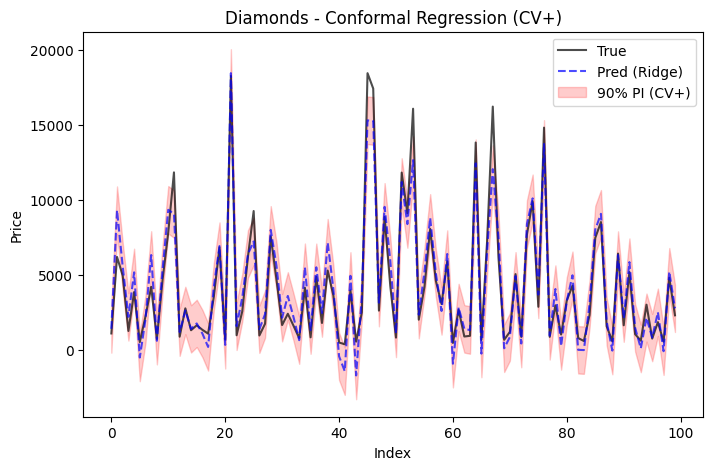

In [ ]:
print("=== RÉGRESSION CONFORME (CV+) : DIAMONDS ===")

base_ridge_dia = Pipeline([
    ("preprocessor", preprocessor_dia),
    ("ridge", Ridge(alpha=1.0))
])

mapie_reg_dia = MapieRegressor(
    estimator=base_ridge_dia,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    method="plus",
)

mapie_reg_dia.fit(X_train_dia, y_train_dia)
y_pred_dia, y_pis_dia = mapie_reg_dia.predict(X_test_dia, alpha=0.1)

lower_dia = y_pis_dia[:, 0, 0]
upper_dia = y_pis_dia[:, 1, 0]

mse_mapie_dia = mean_squared_error(y_test_dia, y_pred_dia)
r2_mapie_dia  = r2_score(y_test_dia, y_pred_dia)
print(f"MSE={mse_mapie_dia:.2f}, R²={r2_mapie_dia:.3f}")

n_plot = 100
plt.figure(figsize=(8,5))
plt.plot(y_test_dia.values[:n_plot], 'k-', label="True", alpha=0.7)
plt.plot(y_pred_dia[:n_plot], 'b--', label="Pred (Ridge)", alpha=0.7)
plt.fill_between(range(n_plot), lower_dia[:n_plot], upper_dia[:n_plot],
                 color='red', alpha=0.2, label="90% PI (CV+)")
plt.title("Diamonds - Conformal Regression (CV+)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()


#### jacknife

=== RÉGRESSION CONFORME (Jackknife+) : DIAMONDS ===
MSE=1329968.67, R²=0.917


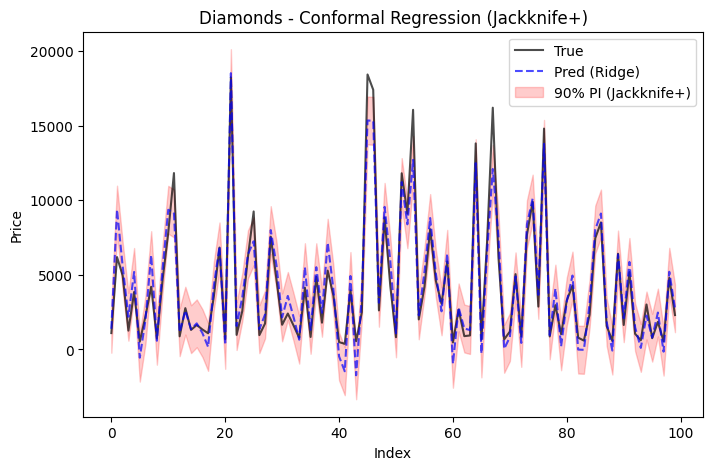

In [ ]:

print("=== RÉGRESSION CONFORME (Jackknife+) : DIAMONDS ===")

base_ridge_dia = Pipeline([
    ("preprocessor", preprocessor_dia),
    ("ridge", Ridge(alpha=1.0))
])

mapie_reg_dia = MapieRegressor(
    estimator=base_ridge_dia,
    cv="split",  # Active le mode Jackknife
    method="plus"
)

mapie_reg_dia.fit(X_train_dia, y_train_dia)
y_pred_dia, y_pis_dia = mapie_reg_dia.predict(X_test_dia, alpha=0.1)

lower_dia_jackknife = y_pis_dia[:, 0, 0]
upper_dia_jackknife = y_pis_dia[:, 1, 0]

mse_mapie_dia = mean_squared_error(y_test_dia, y_pred_dia)
r2_mapie_dia  = r2_score(y_test_dia, y_pred_dia)
print(f"MSE={mse_mapie_dia:.2f}, R²={r2_mapie_dia:.3f}")

n_plot = 100
plt.figure(figsize=(8,5))
plt.plot(y_test_dia.values[:n_plot], 'k-', label="True", alpha=0.7)
plt.plot(y_pred_dia[:n_plot], 'b--', label="Pred (Ridge)", alpha=0.7)
plt.fill_between(range(n_plot), lower_dia_jackknife[:n_plot], upper_dia_jackknife[:n_plot],
                 color='red', alpha=0.2, label="90% PI (Jackknife+)")
plt.title("Diamonds - Conformal Regression (Jackknife+)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()


#### diff

In [ ]:
width_cv_plus = (upper_dia - lower_dia).mean()
width_jackknife = (upper_dia_jackknife - lower_dia_jackknife).mean()

print(f"Largeur moyenne des intervalles (CV+): {width_cv_plus:.2f}")
print(f"Largeur moyenne des intervalles (Jackknife+): {width_jackknife:.2f}")


Largeur moyenne des intervalles (CV+): 3163.41
Largeur moyenne des intervalles (Jackknife+): 3211.35


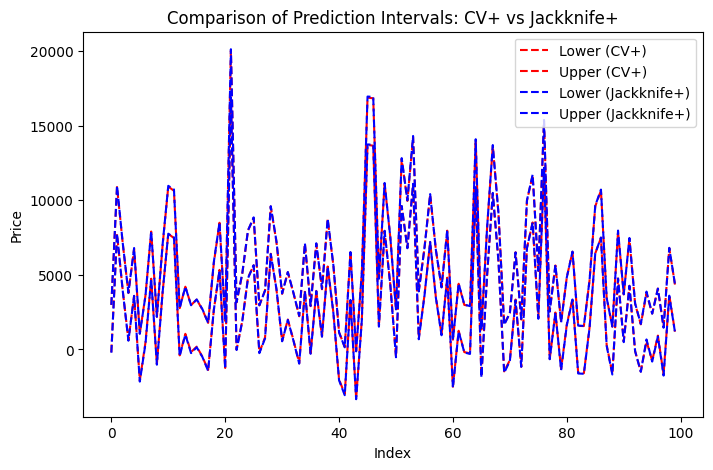

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(n_plot), lower_dia[:n_plot], 'r--', label="Lower (CV+)")
plt.plot(range(n_plot), upper_dia[:n_plot], 'r--', label="Upper (CV+)")
plt.plot(range(n_plot), lower_dia_jackknife[:n_plot], 'b--', label="Lower (Jackknife+)")
plt.plot(range(n_plot), upper_dia_jackknife[:n_plot], 'b--', label="Upper (Jackknife+)")
plt.legend()
plt.title("Comparison of Prediction Intervals: CV+ vs Jackknife+")
plt.xlabel("Index")
plt.ylabel("Price")
plt.show()


# Classification Conforme - Introduction
Dans cette section, nous explorons deux méthodes de classification conforme pour analyser les performances d'un modèle de classification sur le dataset **CICIDS2017**.

## Méthodes utilisées :

1. **Classification Conforme avec méthode basée sur les scores**  
   - Cette méthode génère des ensembles de prédiction en utilisant les scores de classification ou les probabilités pour inclure les classes les plus probables jusqu'à atteindre un niveau de confiance donné.
   - Nous appliquons cette approche avec un modèle Random Forest calibré et un réseau de neurones (MLP). Les ensembles prédits reflètent les classes les plus probables pour chaque exemple.

2. **Classification Conforme avec SCP (Set Conformal Prediction)**  
   - Cette méthode calcule des ensembles de prédiction basés sur les scores cumulatifs, ce qui est particulièrement adapté aux problèmes multi-classes ou binaires.
   - Nous utilisons cette méthode avec un modèle MLP pour analyser la taille des ensembles prédits et leur capacité à inclure la classe réelle (couverture).


## Classification Standard

Dans cette section, nous utilisons un modèle **Random Forest** pour effectuer une classification standard (sans prédiction conforme) sur le dataset CICIDS2017.


In [ ]:
clf_rf_standard = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

clf_rf_standard.fit(X_train, y_train)

y_pred_standard = clf_rf_standard.predict(X_test)

# Évaluer les performances
accuracy_standard = accuracy_score(y_test, y_pred_standard)

print(f"Accuracy (Classification Standard): {accuracy_standard:.3f}")




Accuracy (Classification Standard): 0.539


In [ ]:
# Afficher un rapport de classification
from sklearn.metrics import classification_report

print("Classification Report (Standard):")
print(classification_report(y_test, y_pred_standard))

Classification Report (Standard):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       838
           1       0.00      0.00      0.00        34
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.10      0.50      0.16        10
          25       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         1
          36       0.00      0.00      0.00        12
          41       0.00      0.00      0.00         1
          42       1.00      1.00      1.00         6
          43       1.00      0.44      0.62         9
          44       1.00      0.09      0.16        67
          45       1.00      0.91      0.95        11
          46       1.00      0.50      0.67    

## Dataset CICIDS2017 :
- **Fichiers utilisés** :
  - `Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv` : Exemples de trafic réseau associés à des attaques de type Port Scan.
  - `Monday-WorkingHours.pcap_ISCX.csv` : Exemples de trafic réseau normal.

- **Colonnes sélectionnées** :
  - `Flow Duration`
  - `Fwd Packet Length Mean`
  - `Total Backward Packets`
  - `Label` (cible : 0 = normal, 1 = attaque)

- Les données sont équilibrées et échantillonnées pour une analyse claire des performances.



### 1. **Classification Conforme avec méthode basée sur les scores**  


In [ ]:

file_attack = "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
file_normal = "Monday-WorkingHours.pcap_ISCX.csv"

data_attack = pd.read_csv(file_attack,nrows=50000)
data_normal = pd.read_csv(file_normal,nrows=50000)

data_attack.columns = data_attack.columns.str.strip()
data_normal.columns = data_normal.columns.str.strip()

selected_columns = [
    "Flow Duration",
    "Fwd Packet Length Mean",
    "Total Backward Packets",
    "Label"
]

data_attack = data_attack[selected_columns]
data_normal = data_normal[selected_columns]

# Ajout de la classe
data_attack["Label"] = 1  # Attaque
data_normal["Label"] = 0  # Normal

data = pd.concat([data_attack, data_normal], ignore_index=True).sample(frac=1, random_state=42)

X = data.drop("Label", axis=1)
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf_rf = RandomForestClassifier(random_state=42, n_estimators=100)

calibrated_clf = CalibratedClassifierCV(
    estimator=clf_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method="sigmoid",
)
calibrated_clf.fit(X_train, y_train)

mapie_clf = MapieClassifier(
    estimator=calibrated_clf,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    method="score"
)
mapie_clf.fit(X_train, y_train)

alpha_list = [0.05, 0.10, 0.20]
y_pred, pred_sets = mapie_clf.predict(X_test, alpha=alpha_list)

def print_sample_predictions():
    for i in range(5):
        true_label = y_test.iloc[i]
        print(f"Sample {i} - True: {true_label} - PredSet alpha=0.05: {pred_sets[i, 0]}")

print_sample_predictions()

avg_size_set_95 = np.mean([len(s) for s in pred_sets[:, 0]])
print(f"Taille moyenne set (95%): {avg_size_set_95:.2f}")

correct_coverage_count = 0
for i in range(len(y_test)):
    if y_test.iloc[i] in pred_sets[i, 0]:
        correct_coverage_count += 1
coverage_95 = correct_coverage_count / len(y_test)
print(f"Coverage (alpha=0.05 => ~95%) = {coverage_95:.3f}")

# Évaluer l'exactitude de la prédiction ponctuelle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Sample 0 - True: 1 - PredSet alpha=0.05: [ True  True False]
Sample 1 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Sample 2 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Sample 3 - True: 1 - PredSet alpha=0.05: [ True  True False]
Sample 4 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Taille moyenne set (95%): 3.00
Coverage (alpha=0.05 => ~95%) = 0.415
Accuracy: 0.707


### 2. **Classification Conforme avec SCP (Set Conformal Prediction)**  


In [ ]:
# Initialiser le classifieur Mapie avec une méthode adaptée au binaire
mapie_clf_binary = MapieClassifier(
    estimator=mlp_clf,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    method="score"  # Méthode compatible avec les problèmes binaires
)

# Entraîner le modèle Mapie
mapie_clf_binary.fit(X_train, y_train)

# Prédictions conformes avec la méthode "score"
alpha_list = [0.05, 0.10, 0.20]
y_pred_binary, pred_sets_binary = mapie_clf_binary.predict(X_test, alpha=alpha_list)

# Exemple de quelques prédictions
def print_sample_predictions_binary():
    for i in range(5):
        true_label = y_test.iloc[i]
        print(f"Sample {i} - True: {true_label} - PredSet alpha=0.05: {pred_sets_binary[i, 0]}")

print_sample_predictions_binary()

# Taille moyenne des ensembles prédits (pour alpha=0.05)
avg_size_set_95_binary = np.mean([len(s) for s in pred_sets_binary[:, 0]])
print(f"Taille moyenne set (95%) avec méthode adaptée : {avg_size_set_95_binary:.2f}")

# Calcul de la couverture pour alpha=0.05
correct_coverage_count_binary = 0
for i in range(len(y_test)):
    if y_test.iloc[i] in pred_sets_binary[i, 0]:
        correct_coverage_count_binary += 1
coverage_95_binary = correct_coverage_count_binary / len(y_test)
print(f"Coverage (alpha=0.05 => ~95%) = {coverage_95_binary:.3f}")

# Évaluer l'exactitude de la prédiction ponctuelle
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy (Prédiction ponctuelle) : {accuracy_binary:.3f}")


Sample 0 - True: 1 - PredSet alpha=0.05: [ True  True  True]
Sample 1 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Sample 2 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Sample 3 - True: 1 - PredSet alpha=0.05: [ True  True  True]
Sample 4 - True: 0 - PredSet alpha=0.05: [ True  True  True]
Taille moyenne set (95%) avec méthode adaptée : 3.00
Coverage (alpha=0.05 => ~95%) = 0.524
Accuracy (Prédiction ponctuelle) : 0.602
